# **Framework for Near-Real Time Sensor-Agnostic Water Classification**

A new image is acquired at T1. Landsat (and potentially Sentinel-2) water masks are aggregated from a period of time T0 (T1-3months). Assuming no significant (TBD) change between T0 and T1 in water extent, it should be possible to identify likely change pixels at the boundary of class distributions if sampled across a representative a large enough area (TBD). Omitting such potential change features enables a significant no. training samples at T1 and these may be used to provide water (+ probability) masks at T1 for all clearsky pixels at T1.

Assumptions
- At least 'somewhat' a complete water mask can be obtained by generating a water summary product for T0
- There is a sufficient area of 'clearsky' within the T1 image
- Class transitions are on a sufficiently limited scale that either
    - (1) they do not need to be omitted and model selection will be robust enough to treat them as outliers, or
    - (2) they can be identified as outliers from the major class distributions using skewness/kurtosis
- 

need bespoke roi module

In [11]:
!pip install salem
!pip install asynchronousfilereader

In [1]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 
from datetime import datetime
from datetime import timedelta
import pandas as pd
import geopandas as gpd
from shapely import wkt
import rasterio
import rasterio.features
import salem
import os
import gc
from subprocess import Popen, PIPE, STDOUT

import glob
from dateutil.parser import parse
import uuid

# sac-specific
from sac_utils.createAOI import create_lat_lon
from ard_workflows.utils.prep_utils import s3_list_objects, s3_download, s3_upload_cogs, create_yaml, cog_translate, get_geometry
from dataset_index_from_s3_bucket import main as ind

# dc-specific
from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
dc = Datacube()
from utils_dcal.data_cube_utilities.import_export import export_xarray_to_geotiff

# ml stuff
from sklearn.ensemble import RandomForestClassifier

import utils_dcal.data_cube_utilities.data_access_api as dc_api
api = dc_api.DataAccessApi()

# dask stuff
import dask.array
import dask
from dask.distributed import Client
client = Client('dask-scheduler.dask.svc.cluster.local:8786')
client

Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 40 Memory: 168.65 GB


# **Scope Job List**

overall aoi and search criteria to assertain datasets across which to run app

In [2]:
left = "POLYGON((177.0476310089793 -16.369503321696154,179.1570060089793 -16.369503321696154,179.1570060089793 -19.214508611536765,177.0476310089793 -19.214508611536765,177.0476310089793 -16.369503321696154))"
overall_aoi_wkt = left
overall_aoi_gdf = pd.DataFrame({'geometry':[overall_aoi_wkt]})
overall_aoi_gdf['geometry'] = overall_aoi_gdf['geometry'].apply(wkt.loads)
overall_aoi_gdf['aoi'] = 'aoi'
overall_aoi_gdf = gpd.GeoDataFrame(overall_aoi_gdf, geometry='geometry', crs={"init": "epsg:4326"}) # using {init} important
latitude, longitude = create_lat_lon(overall_aoi_wkt)

search_prods = ["s2_esa_sr_granule", "ls8_usgs_sr_scene"]

def get_bands(prod):
    if "s2_esa" in prod:
        measurements = ["green","red","blue","nir","swir1","swir2", "scene_classification"]
    elif "usgs_sr" in prod:
        measurements = ["green","red","blue","nir","swir1","swir2", "pixel_qa"]
    elif "gamma0" in prod:
        measurements = ["vv","vh","layovershadow_mask"]
    return measurements

def get_res(prod):
    if "s2_esa" in prod:
        res = (-10,10)
    elif "usgs_sr" in prod:
        res = (-30,30)
    elif "gamma0" in prod:
        res = (-20,20)
    return res

latitude, longitude

((-19.214508611536765, -16.369503321696154),
 (177.0476310089793, 179.1570060089793))

**find datasets** - *note*: lat lon returns all anti-meridian scenes at that longitude, so need additional filtering here

In [3]:
ds = []
for search_prod in search_prods:
    ds = ds + dc.find_datasets(
        product=search_prod,
        lat=latitude,
        lon=longitude,
    #     measurements = measurements,
        )
              
len(ds), # vars(ds[0])

(2811,)

In [4]:
ds[0]

Dataset <id=867d04cf-4435-5186-9f9b-fa964341c603 type=s2_esa_sr_granule location=s3://public-eo-data/common_sensing/fiji/sentinel_2/S2B_MSIL1C_20180901T221929_T60KXF/datacube-metadata.yaml>

get **ds footprints & dates** - *note*: ds.extent.wkt doesn't play nice so use yml metadata as already in 4326 wkt

,Date,xmin,xmax,ymin,ymax,Platform,id,all_meta,geometry,des
2017,2013-04-25 22:14:09,176.609252,178.736003,-16.898926,-14.904573,LANDSAT_8,c51dce4a-87e3-5158-a710-c820a3846580,Dataset <id=c51dce4a-87e3-5158-a710-c820a38465...,POLYGON ((176.6092518308768 -16.89892572427777...,True
2018,2013-04-25 22:14:33,176.273944,178.417781,-18.340538,-16.349256,LANDSAT_8,5d4255e9-9072-5623-a5e2-de0088dcf018,Dataset <id=5d4255e9-9072-5623-a5e2-de0088dcf0...,POLYGON ((176.2739436539554 -18.34053833348177...,True


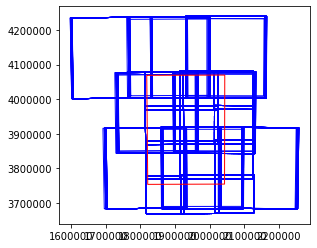

In [5]:
def parsemetaparams(df):
    g = []
    for index, row in df.iterrows():
        g.append(f"Polygon(({row.xmin} {row.ymin}, {row.xmax} {row.ymin}, {row.xmax} {row.ymax}, {row.xmin} {row.ymax}, {row.xmin} {row.ymin}))")
    df['geometry'] = g
    return df
df=pd.DataFrame({
    'Date': [i.metadata.time[0] for i in ds],
    'xmin': [i.metadata.lon[0] for i in ds],
    'xmax': [i.metadata.lon[1] for i in ds],
    'ymin': [i.metadata.lat[0] for i in ds],
    'ymax': [i.metadata.lat[1] for i in ds],
    'Platform': [i.metadata.platform for i in ds],
    'id': [i.metadata.id for i in ds],
    'all_meta': [i for i in ds]
})
df = parsemetaparams(df)
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=({"init":"epsg:4326"}))
# repro and intersect to omit potemtial am scenes
a = overall_aoi_gdf.to_crs({"init": "epsg:3460"}) # speed intersect up by repro-ing aoi first
gdf['des'] = gdf.to_crs({"init": "epsg:3460"}).geometry.map(lambda x: x.intersects(a.geometry.any())) # repro and test intersect
gdf = gdf[gdf['des']==True] # subset
gdf = gdf.sort_values(by=['Date'], ascending=True)

# check expected footprints etc.
fig, ax = plt.subplots()
gdf.to_crs({"init": "epsg:3460"}).plot(facecolor="",edgecolor="b", ax=ax);
overall_aoi_gdf.to_crs({"init": "epsg:3460"}).plot(facecolor="",edgecolor="r", ax=ax);
gdf.head(2)

create jobs off **grouped mosaic** datasets & determine **outer extent**

,Date,xmin,xmax,ymin,ymax,Platform,id,all_meta,geometry,des
2017,2013-04-25 22:14:09,176.609252,178.736003,-16.898926,-14.904573,LANDSAT_8,c51dce4a-87e3-5158-a710-c820a3846580,Dataset <id=c51dce4a-87e3-5158-a710-c820a38465...,POLYGON ((176.6092518308768 -16.89892572427777...,True
2018,2013-04-25 22:14:33,176.273944,178.417781,-18.340538,-16.349256,LANDSAT_8,5d4255e9-9072-5623-a5e2-de0088dcf018,Dataset <id=5d4255e9-9072-5623-a5e2-de0088dcf0...,POLYGON ((176.2739436539554 -18.34053833348177...,True


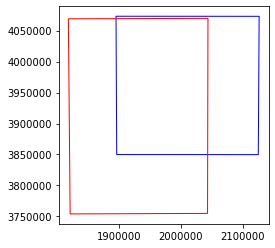

In [6]:
n = 5
# check expected footprints etc.
fig, ax = plt.subplots()
gdf.iloc[[n]].to_crs({"init": "epsg:3460"}).plot(facecolor="",edgecolor="b", ax=ax);
overall_aoi_gdf.to_crs({"init": "epsg:3460"}).plot(facecolor="",edgecolor="r", ax=ax);
gdf.head(2)

In [7]:
print(gdf.iloc[[n]].all_meta.values[0].type.name)
# vars(gdf.iloc[[n]].all_meta.values[0])

ls8_usgs_sr_scene


In [8]:
# buffer
buffer_path = './FijiCoastalBuffer_shp.shp'
# original scene meta for yaml + export later
original_metadata = gdf.iloc[[n]]['all_meta'].values[0]
# format acquistion date of image being classified
# T = pd.to_datetime(d).date()
T = pd.to_datetime(gdf.iloc[[n]].Date.values[0])
# add a day on to satisfy dc.load time range req
T1 = (str(T),str(T)) # str(pd.to_datetime(T +pd.DateOffset(0)).date())) # no off-set for now
# create T0 range of 90 days prior to acquisition
T0 = (str(pd.to_datetime(T + pd.DateOffset(-91)).date()), str(pd.to_datetime(T + pd.DateOffset(-1)).date()))
# lat and lon taken from image metadate
latitude, longitude = create_lat_lon(str(gdf.iloc[[n]].geometry.values[0]))
# b = scenes.total_bounds
# latitude, longitude = (b[1],b[3]),(b[0],b[2])
# hopefully fiji crs avoids major AM issues
output_crs = "EPSG:32760"

T1_prod = gdf.iloc[[n]].all_meta.values[0].type.name
T1_measurements = get_bands(T1_prod)
T1_vars = T1_measurements[:-1]
ref_channel = T1_measurements[-3] # assume swir1 or vv/vh is in this place
resolution = get_res(T1_prod)

print(latitude, longitude)
print(T1, T0)
print(ref_channel)
print(T1_prod, T1_measurements, resolution)

(-18.35389810727146, -16.33670144402138) (177.7676268381298, 179.9301495881093)
('2013-06-05 22:08:39', '2013-06-05 22:08:39') ('2013-03-06', '2013-06-04')
swir1
ls8_usgs_sr_scene ['green', 'red', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa'] (-30, 30)


In [12]:
!ls -lh /home/shared/intermediate/

total 0


In [10]:
rm -rf /home/shared/intermediate/*

In [22]:
cp /home/shared/intermediate/S2B_MSIL1C_20180901T221929_T60KXF/datacube-metadata.yaml ./datacube-metadata.yaml

In [17]:
def get_bands(prod):
    if "s2_esa" in prod:
        measurements = ["green","red","blue","nir","swir1","swir2", "scene_classification"]
    elif "usgs_sr" in prod:
        measurements = ["green","red","blue","nir","swir1","swir2", "pixel_qa"]
    elif "gamma0" in prod:
        measurements = ["vv","vh","layovershadow_mask"]
    return measurements

def get_res(prod):
    if "s2_esa" in prod:
        res = (-10,10)
    elif "usgs_sr" in prod:
        res = (-30,30)
    elif "gamma0" in prod:
        res = (-20,20)
    return res

def get_valid(ds, prod):
    # Identify pixels with valid data
    if 'usgs' in prod:
        good_quality = (
            (ds.pixel_qa == 322)  | # clear
            (ds.pixel_qa == 386)  |
            (ds.pixel_qa == 834)  |
            (ds.pixel_qa == 898)  |
            (ds.pixel_qa == 1346) |
            (ds.pixel_qa == 324)  | # water
            (ds.pixel_qa == 388)  |
            (ds.pixel_qa == 836)  |
            (ds.pixel_qa == 900)  |
            (ds.pixel_qa == 1348)
        )
    elif 's2_esa' in prod:
        good_quality = (
            (ds.scene_classification == 2) | # mask in DARK_AREA_PIXELS
        #     (ds.scene_classification == 3) | # mask in CLOUD_SHADOWS
            (ds.scene_classification == 4) | # mask in VEGETATION
            (ds.scene_classification == 5) | # mask in NOT_VEGETATED
            (ds.scene_classification == 6) | # mask in WATER
            (ds.scene_classification == 7)   # mask in UNCLASSIFIED
        )
    return good_quality

def band_name_water(prod_path):
    """
    Determine l8 band of individual product from product name
    from path to specific product file
    """

    prod_name = os.path.basename(prod_path)
    parts = prod_name.split('_')
    prod_name = f"{parts[-2]}_{parts[-1][:-4]}"

    prod_map = {
        "watermask": 'watermask',
        "waterprob": 'waterprob'
    }
    layer_name = prod_map[prod_name]
    return layer_name

def yaml_prep_water(scene_dir, original_yml):
    """
    Prepare individual wofs directory containing L8/S2/S1 cog water products.
    """
    # scene_name = scene_dir.split('/')[-2][:26]
    scene_name = scene_dir.split('/')[-2]
    print ( "Preparing scene {}".format(scene_name) )
    print ( "Scene path {}".format(scene_dir) )
    
    # find all cog prods
    prod_paths = glob.glob(scene_dir + '*water*.tif')
    # print ( 'paths: {}'.format(prod_paths) )
    # for i in prod_paths: print ( i )
    
    # date time assumed eqv for start and stop - this isn't true and could be 
    # pulled from .xml file (or scene dir) not done yet for sake of progression
    t0=parse(str(datetime.strptime(original_yml['extent']['center_dt'], '%Y-%m-%d %H:%M:%S')))
    # print ( t0 )
    t1=t0
    # print ( t1 )
    
    # name image product
    images = {
        prod_path.split('_')[-1][:9]: {
            'path': str(prod_path.split('/')[-1])
        } for prod_path in prod_paths
    }
    print ( images )

    # trusting bands coaligned, use one to generate spatial bounds for all
    projection, extent = get_geometry(os.path.join(str(scene_dir), images['watermask']['path']))
#     extent = 
    print(projection, extent)
    
    new_id = str(uuid.uuid5(uuid.NAMESPACE_URL, f"{scene_name}_water"))
    
    return {
        'id': new_id,
        'processing_level': original_yml['processing_level'],
        'product_type': "mlwater",
        'creation_dt': str(datetime.today().strftime('%Y-%m-%d %H:%M:%S')),
        'platform': {  
            'code': original_yml['platform']['code']
        },
        'instrument': {
            'name': original_yml['instrument']['name']
        },
        'extent': {
            'coord': original_yml['extent']['coord'],
            'from_dt': str(t0),
            'to_dt': str(t1),
            'center_dt': str(t0 + (t1 - t0) / 2)
        },
        'format': {
            'name': 'GeoTiff'
        },
        'grid_spatial': {
            'projection': projection
        },
        'image': {
            'bands': images
        },
        'lineage': {
            'source_datasets': original_yml['lineage']['source_datasets'],
        }  
    }


def mlwater(T1meta, T0range=-91, inter_dir='/home/shared/intermediate/', s3_bucket='public-eo-data',
            s3_dir='common_sensing/fiji/ml_water/', mask="./FijiCoastalBuffer_shp.shp", output_crs="EPSG:3460"):
    """
    T1meta: metadata of single image returned from dc.find_dataset()
    T0range: n_days and direction from T1 from which to aggregate existing water masks. Default: Q1
    mask: esri shapefile of estent withinwhich to train & predict
    """
    
    try:
        # extract T1ds params
        T = pd.to_datetime(T1meta.metadata.time[0])
        T1 = (str(T),str(T))
        T0 = (str(pd.to_datetime(T + pd.DateOffset(T0range)).date()), 
              str(pd.to_datetime(T + pd.DateOffset(-1)).date()))

        xmin = T1meta.metadata.lon[0]
        xmax = T1meta.metadata.lon[1]
        ymin = T1meta.metadata.lat[0]
        ymax = T1meta.metadata.lat[1]
        T1wkt = f"Polygon(({xmin} {ymin}, {xmax} {ymin}, {xmax} {ymax}, {xmin} {ymax}, {xmin} {ymin}))"
        latitude, longitude = create_lat_lon(T1wkt)

        T1prod = T1meta.type.name
        T1measurements = get_bands(T1prod)
        T1vars = T1measurements[:-1]
        ref_channel = T1measurements[-3] # assume swir1 or vv/vh is in this place
        resolution = get_res(T1prod)

        print(T1, T0, T1wkt, T1prod, T1measurements, T1vars, ref_channel, latitude, longitude)


        # create T0 water mask - need to grab all masks efficiently...
        product = ['ls8_water_classification','ls7_water_classification','ls5_water_classification',
                   'ls4_water_classification','s2_water_classification','s1_water_classification']
        water_dataset = dc.load(
            product=product[0],
            time=T0,  
            lat=latitude,
            lon=longitude,
            output_crs=output_crs,
            resolution=resolution,
            measurements = ['water'],
            group_by='solar_day',
            dask_chunks={
                #'time': 1,
                'x': 1000,
                'y': 1000,
            }
        )
        print(water_dataset)

        # Identify and mask pixels with valid data
        good_quality = (
            (water_dataset.water >= 0) # no data
        )
        water_dataset = water_dataset.where(good_quality)
        # mask to aoi
        shdf = salem.read_shapefile(mask)
        water_dataset.attrs['pyproj_srs'] = str(water_dataset.attrs['crs'])
        water_dataset = water_dataset.salem.roi(shape=shdf, other=np.nan)    
        # design water summary and compute
        mean_dataset = water_dataset.water.mean(dim='time')
        mean_dataset = mean_dataset.compute()
        client.restart()
        # re-format to binary mask
        waterpres_prob = 0.5
        T0_nd_water = np.isnan(mean_dataset)
        T0_water = mean_dataset.where((mean_dataset < waterpres_prob) | (T0_nd_water == True), 1) # fix > prob to water
        T0_water = T0_water.where((T0_water >= waterpres_prob) | (T0_nd_water == True), 0) # fix < prob to no water 
        # option plot
#         fig, ax = plt.subplots(figsize=(50,50))
#         ax.imshow(T0_water)    

        # load T1 image
        T1_dataset = dc.load(
            product=T1prod,
            time=T1, # 
            lat=latitude,
            lon=longitude,
            output_crs=output_crs,
            resolution=resolution,
            measurements = T1measurements,
        #     group_by='solar_day', # for some reason groupby applies when not selected...
            dask_chunks={
                #'time': 1,
                'x': 1000,
                'y': 1000,
            }
        )
        # identify and mask pixels with valid data
        good_quality = get_valid(T1_dataset, T1prod)
        T1_dataset = T1_dataset.where(good_quality)
        # mask to aoi
        T1_dataset.attrs['pyproj_srs'] = str(T1_dataset.attrs['crs'])
        T1_dataset = T1_dataset.salem.roi(shape=shdf, other=np.nan)
        print(T1_dataset)
        T1_img = T1_dataset.isel(time = 0)
        # optional plot
#         fig, ax = plt.subplots(figsize=(50,50))
#         ax.imshow(T1_img[ref_channel])

        # Training
        # prep
        # create mask
        T0_nd_img = np.isnan(T1_img)[ref_channel]
        T0_nd = T0_nd_water.where((T0_nd_img == False),True)
        # apply mask
        Ytrain = T0_water.where((T0_nd == False))
        Xtrain = T1_img.where((T0_nd == False))
        T0_nd_img = None
        T0_nd = None
        T0_water = None
        T0_nd_water = None
        # numpify
        des_vars = T1vars
        lenx, leny = np.shape(Xtrain[ref_channel]) # dims of each raster
        dsvals = np.zeros([len(des_vars),lenx, leny]) #set up array based on shape of xr and no. des bands
        for i, m in zip(np.arange(0,len(Xtrain.data_vars),1), Xtrain.variables): # loop through bands in xr
            print(i, m)
            if m in des_vars: # only want relevant channels
                vals = np.array(Xtrain[m].values) # extract only the reflectance values
                dsvals[i,:,:] = vals # append to 'master' ND array
                vals = None
        Xtrain = dsvals.reshape(dsvals.shape[0], lenx * leny)  # reshape into nbands x 1D arrays
        Ytrain = Ytrain.values.flatten()
        dsvals = None
        Xtrain = np.array([i[~np.isnan(i)] for i in Xtrain])
        Ytrain = Ytrain[~np.isnan(Ytrain)]
        Xtrain = Xtrain.transpose()  # transpose so that bands are read as features
        print('X,Y', Xtrain.shape, Ytrain.shape)
        # model training
        model = RandomForestClassifier(n_estimators=9, 
                                       bootstrap = True,
                                       max_features = 'sqrt',
                                       max_depth=5,
                                       n_jobs=3,
                                       verbose=2
                                      )
        rf = model.fit(Xtrain, Ytrain)
        Xtrain = None
        Ytrain = None


        # Implementation
        # numpify
        lenx, leny = np.shape(T1_img[ref_channel]) # dims of each raster
        dsvals = np.zeros([len(des_vars),lenx, leny]) #set up array based on shape of xr and no. des bands
        for i, m in zip(np.arange(0,len(T1_img.data_vars),1), T1_img.variables): # loop through bands in xr
            print(i, m)
            if m in des_vars: # only want relevant channels
                vals = np.array(T1_img[m].values) # extract only the reflectance values
                dsvals[i,:,:] = vals # append to 'master' ND array
                vals = None
        Ximp = dsvals.reshape(dsvals.shape[0], lenx * leny)  # reshape into nbands x 1D arrays
        dsvals = None
        T1_img = None
        Ximp = Ximp.transpose()  # transpose so that bands are read as features
        foundnans = np.isnan(Ximp)
        Ximp[foundnans] = 0

        predicted = rf.predict(Ximp)
        predicted = np.array(predicted)
        predicted = predicted
        predicted[foundnans[:,0]] = -9999
        predicted = predicted.astype(np.int16)
        predicted = np.reshape(predicted, [lenx, leny])
        predicted_ds = T1_dataset
        predicted_ds['water_mask'] = (('y','x'), predicted)
        predicted = predicted_ds[['water_mask']]
        predicted_ds = None
        predicted.attrs['pyproj_srs'] = str(predicted.attrs['crs'])
        predicted = predicted.salem.roi(shape=shdf, other=1)

        probability = rf.predict_proba(Ximp)[:, 1]
        probability = np.array(probability)
        probability = probability*100
        probability[foundnans[:,0]] = -9999
        probability = probability.astype(np.int16)
        probability = np.reshape(probability, [lenx, leny])
        probability_ds = T1_dataset
        probability_ds['water_prob'] = (('y','x'), probability)
        probability = probability_ds[['water_prob']]
        probability_ds = None
        probability.attrs['pyproj_srs'] = str(probability.attrs['crs'])
        probability = probability.salem.roi(shape=shdf, other=100)

        # optional plot
#         fig, ax = plt.subplots(figsize=(50,50))
#         ax.imshow(predicted.water_mask.where(predicted.water_mask>=0))
#         ax.set_title('Inferred Water Mask')
#         fig, ax = plt.subplots(figsize=(50,50))
#         ax.imshow(probability.water_prob.where(probability.water_prob>=0))
#         ax.set_title('Inferred Water Probability')
#         fig, ax = plt.subplots(figsize=(50,50))
#         ax.imshow(T1_img.swir1)
#         ax.set_title('SWIR1 Channel');

        # Export
        scene_nm = T1meta.uris[0].split('/')[-2] # assumes scenename as dir of indexed metadata 
        inter_prodir = inter_dir + scene_nm + '/'
        os.makedirs(inter_prodir, exist_ok=True)
        out_mask_prod = inter_prodir + scene_nm + '_watermask.tif'
        out_prob_prod = inter_prodir + scene_nm + '_waterprob.tif'
        export_xarray_to_geotiff(predicted, out_mask_prod, bands=['water_mask'], crs=output_crs, x_coord='x', y_coord='y', no_data=-9999)
        export_xarray_to_geotiff(probability, out_prob_prod, bands=['water_prob'], crs=output_crs, x_coord='x', y_coord='y', no_data=-9999)

        Ximp = None
        probability = None
        predicted = None
        T1_dataset = None
        water_dataset = None
        good_quality = None
        foundnans = None
        rf = None
        shdf = None


        # Yaml
        create_yaml(inter_prodir, yaml_prep_water(inter_prodir, T1meta.metadata._doc)) # assumes majority of meta copied from original product yml

        # Upload
        s3_upload_cogs(glob.glob(f'{inter_prodir}*'), s3_bucket, s3_dir)

        # Index
        cmd = f'python3 ./dataset_index_from_s3_bucket.py {s3_bucket} -p {s3_dir}{scene_nm}/ --endpoint_url="http://s3-uk-1.sa-catapult.co.uk" --unsigned_requests --start_date 1960-01-01 --end_date 2030-01-01'
        p = Popen(cmd, shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True)
        out = p.stdout.read()
        print(out)
        
        gc.collect()

        shutil.rmtree(inter_prodir)
        
    except Exception as e:
        print(e)

In [18]:
# should encode to env vars as with docker, not csv
os.environ['AWS_ACCESS_KEY_ID']= "16c353e3c1673eb9556e"
os.environ['AWS_SECRET_ACCESS_KEY']= "fdRkqs1Yb86WVqPtmEPWZZepQ5+h6Nz5og4mWhLv"
# os.environ['AWS_S3_ENDPOINT']=str(pd.read_csv('../aws_creds.csv').AWS_S3_ENDPOINT.values[0])
print(os.environ['AWS_ACCESS_KEY_ID'])

16c353e3c1673eb9556e


In [19]:
len(gdf.all_meta.values)

2192

In [20]:
ds[0]

Dataset <id=867d04cf-4435-5186-9f9b-fa964341c603 type=s2_esa_sr_granule location=s3://public-eo-data/common_sensing/fiji/sentinel_2/S2B_MSIL1C_20180901T221929_T60KXF/datacube-metadata.yaml>

In [ ]:
%%time
for i in gdf.all_meta.values[50:]:
    mlwater(i, -91)


('2013-11-19 22:14:02', '2013-11-19 22:14:02') ('2013-08-20', '2013-11-18') Polygon((176.5865870059984 -16.95854135333371, 178.73936575004015 -16.95854135333371, 178.73936575004015 -14.844906022512376, 176.5865870059984 -14.844906022512376, 176.5865870059984 -16.95854135333371)) ls8_usgs_sr_scene ['green', 'red', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa'] ['green', 'red', 'blue', 'nir', 'swir1', 'swir2'] swir1 (-16.95854135333371, -14.844906022512376) (176.5865870059984, 178.73936575004015)
<xarray.Dataset>
Dimensions:  (time: 19, x: 7725, y: 7839)
Coordinates:
  * time     (time) datetime64[ns] 2013-08-24T22:08:16 ... 2013-11-12T22:08:20
  * y        (y) float64 4.238e+06 4.238e+06 4.238e+06 ... 4.003e+06 4.003e+06
  * x        (x) float64 1.767e+06 1.767e+06 1.767e+06 ... 1.999e+06 1.999e+06
Data variables:
    water    (time, y, x) int16 dask.array<shape=(19, 7839, 7725), chunksize=(1, 1000, 1000)>
Attributes:
    crs:      EPSG:3460
<xarray.Dataset>
Dimensions:   (time: 1, x: 772

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 8 of 9
building tree 9 of 9
0 green


[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    0.3s finished


1 red


In [35]:
import datacube

In [42]:
dc.find_datasets(
        product='s2_water_mlclassification',
        lat=latitude,
        lon=longitude,
    #     measurements = measurements,
        )

[Dataset <id=0b44e2f9-dffd-5663-b244-354c56af6c7b type=s2_water_mlclassification location=s3://public-eo-data/common_sensing/fiji/ml_water/S2B_MSIL1C_20180901T221929_T60KXF/datacube-metadata.yaml>]

# **(1) create T0 water mask (T1-3months)**

**load T0 water masks**

In [38]:
product = ['ls8_water_classification','ls7_water_classification','ls5_water_classification','ls4_water_classification','s2_water_classification','s1_water_classification']
measurements = ['waterprob','watermask']

water_dataset = dc.load(
    product='s2_water_mlclassification',
#     time=, # quarter prior to T1 
    lat=latitude,
    lon=longitude,
    output_crs=output_crs,
    resolution=resolution,
    measurements = measurements,
    group_by='solar_day',
    dask_chunks={
        #'time': 1,
        'x': 1000,
        'y': 1000,
    }
)
water_dataset

<xarray.Dataset>
Dimensions:    (time: 3, x: 7733, y: 7518)
Coordinates:
  * time       (time) datetime64[ns] 2018-08-25T22:29:59 ... 2018-09-04T22:29:59
  * y          (y) float64 8.194e+06 8.194e+06 8.194e+06 ... 7.968e+06 7.968e+06
  * x          (x) float64 5.811e+05 5.811e+05 5.812e+05 ... 8.13e+05 8.131e+05
Data variables:
    waterprob  (time, y, x) int16 dask.array<shape=(3, 7518, 7733), chunksize=(1, 1000, 1000)>
    watermask  (time, y, x) int16 dask.array<shape=(3, 7518, 7733), chunksize=(1, 1000, 1000)>
Attributes:
    crs:      EPSG:32760

In [39]:
# Identify pixels with valid data
good_quality = (
    (water_dataset.watermask >= 0) # no data
)
# Apply mask
water_dataset = water_dataset.where(good_quality)

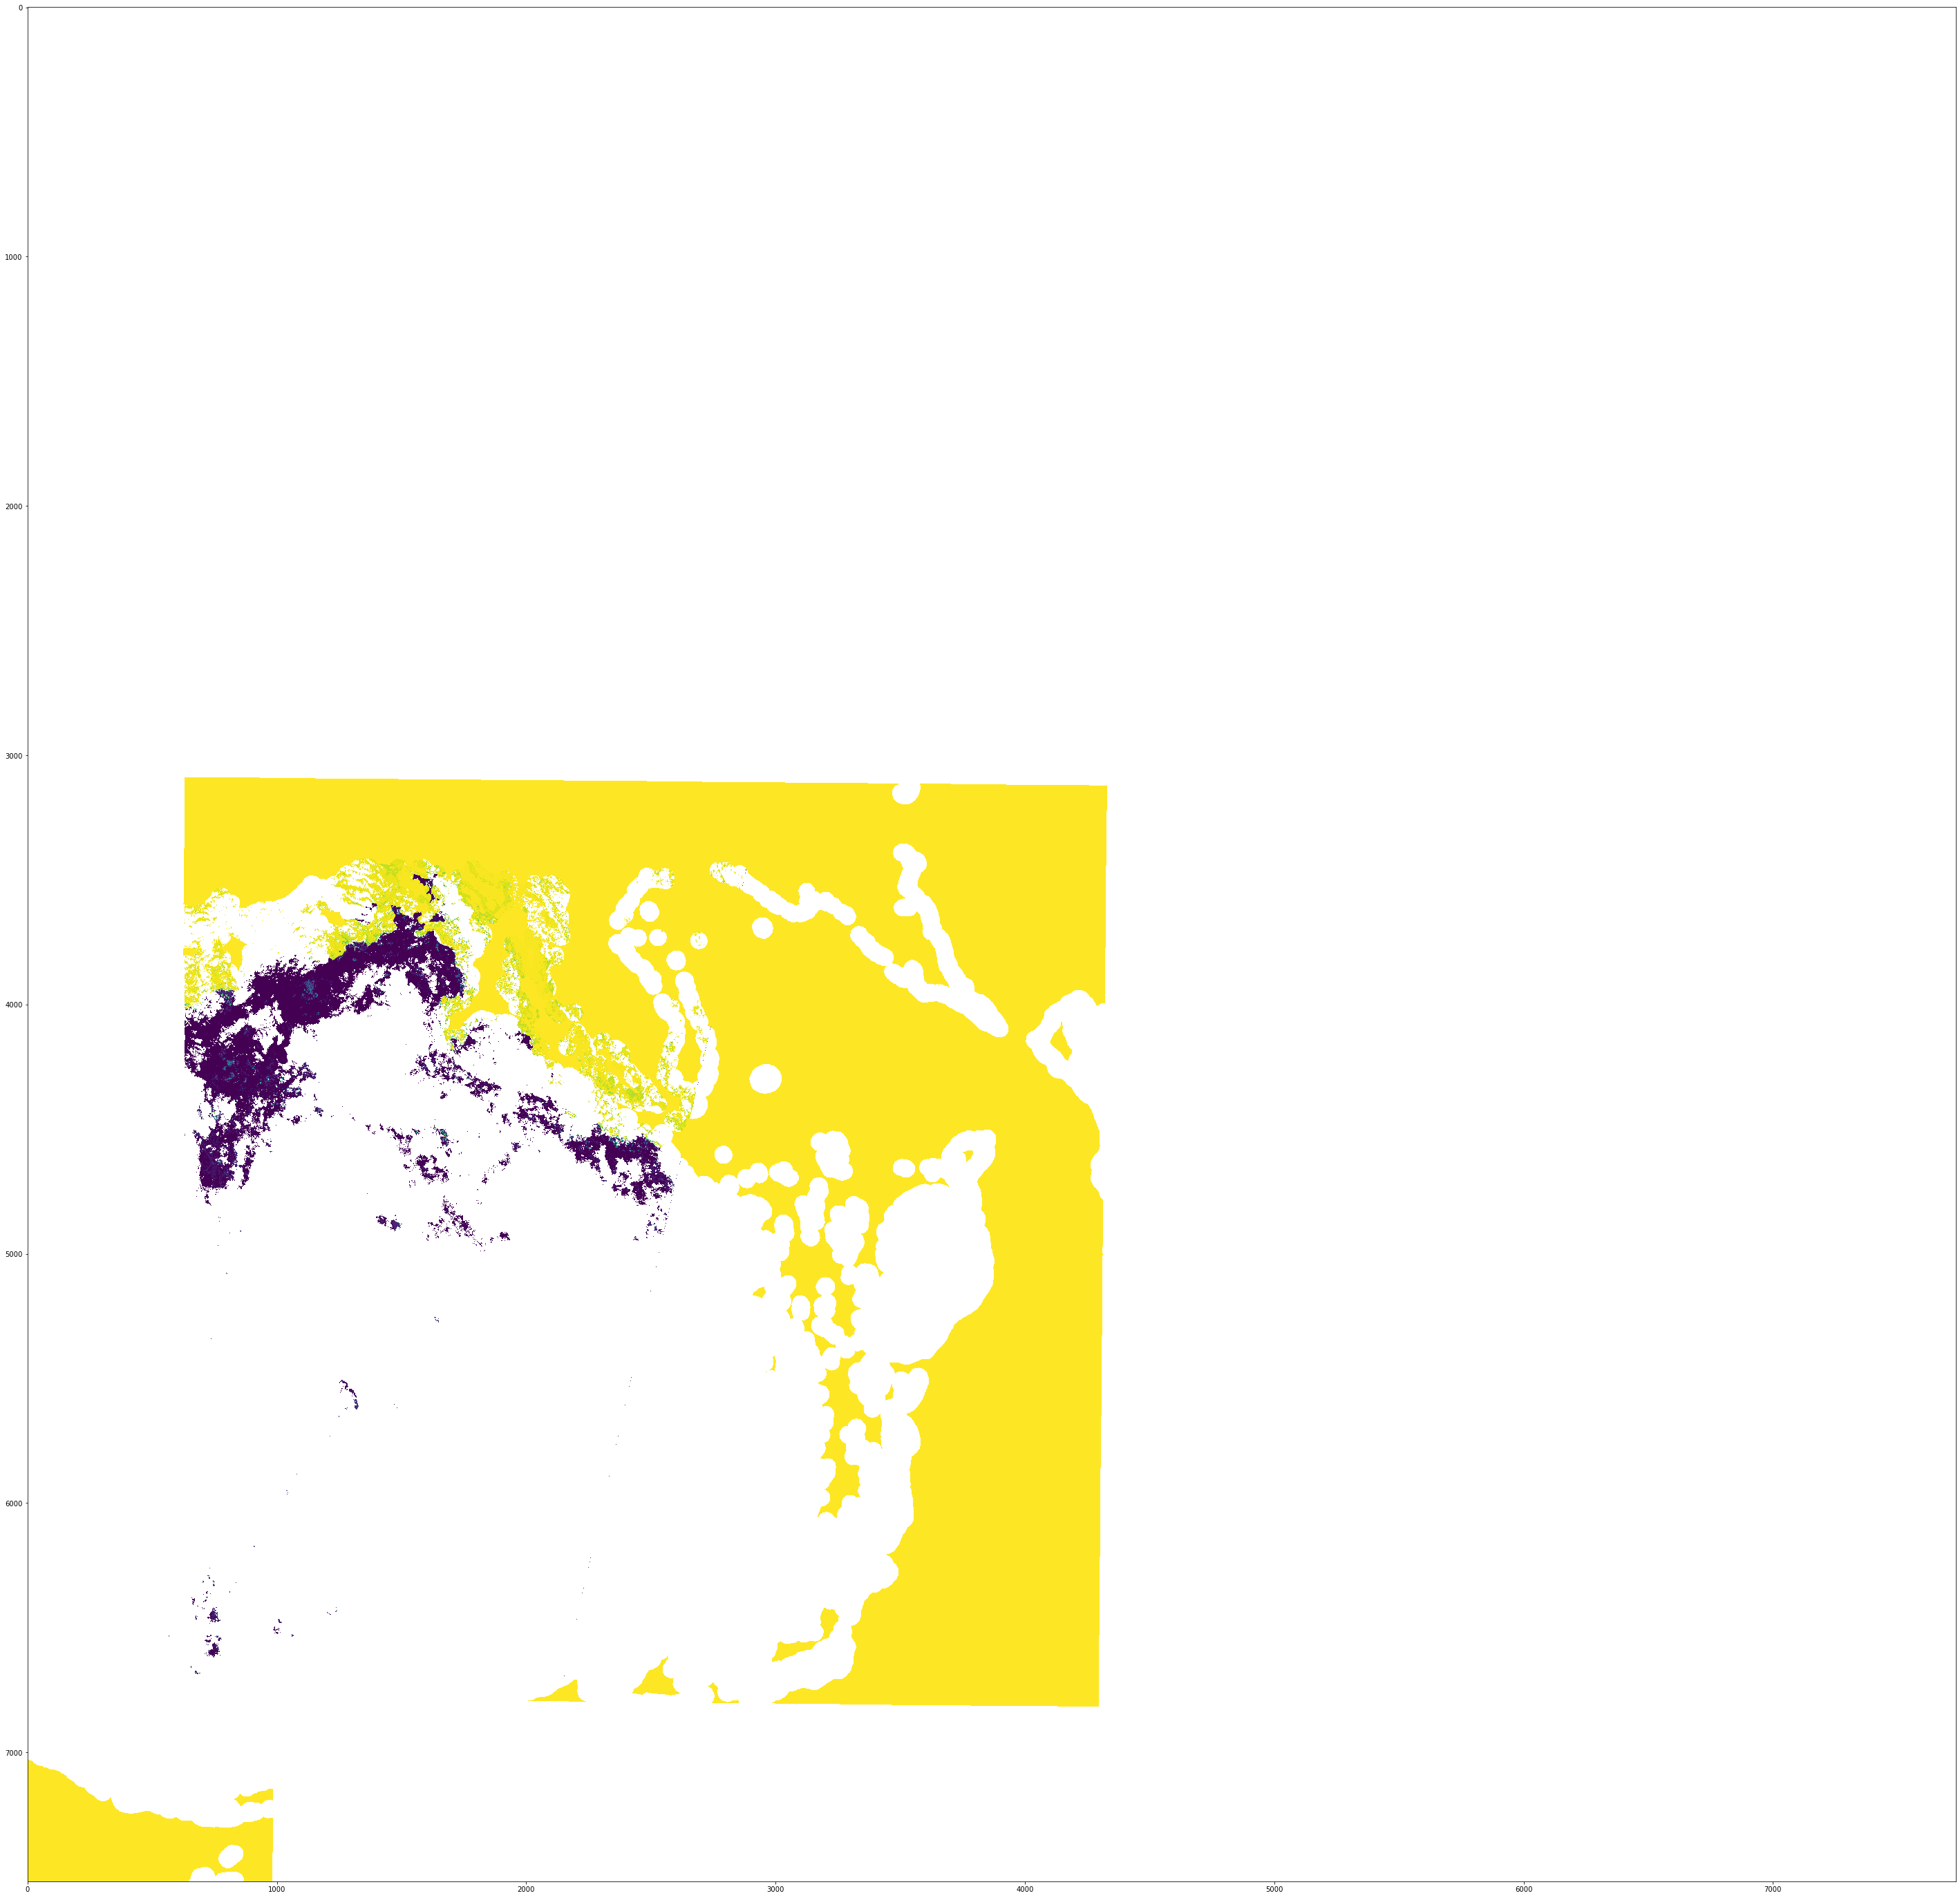

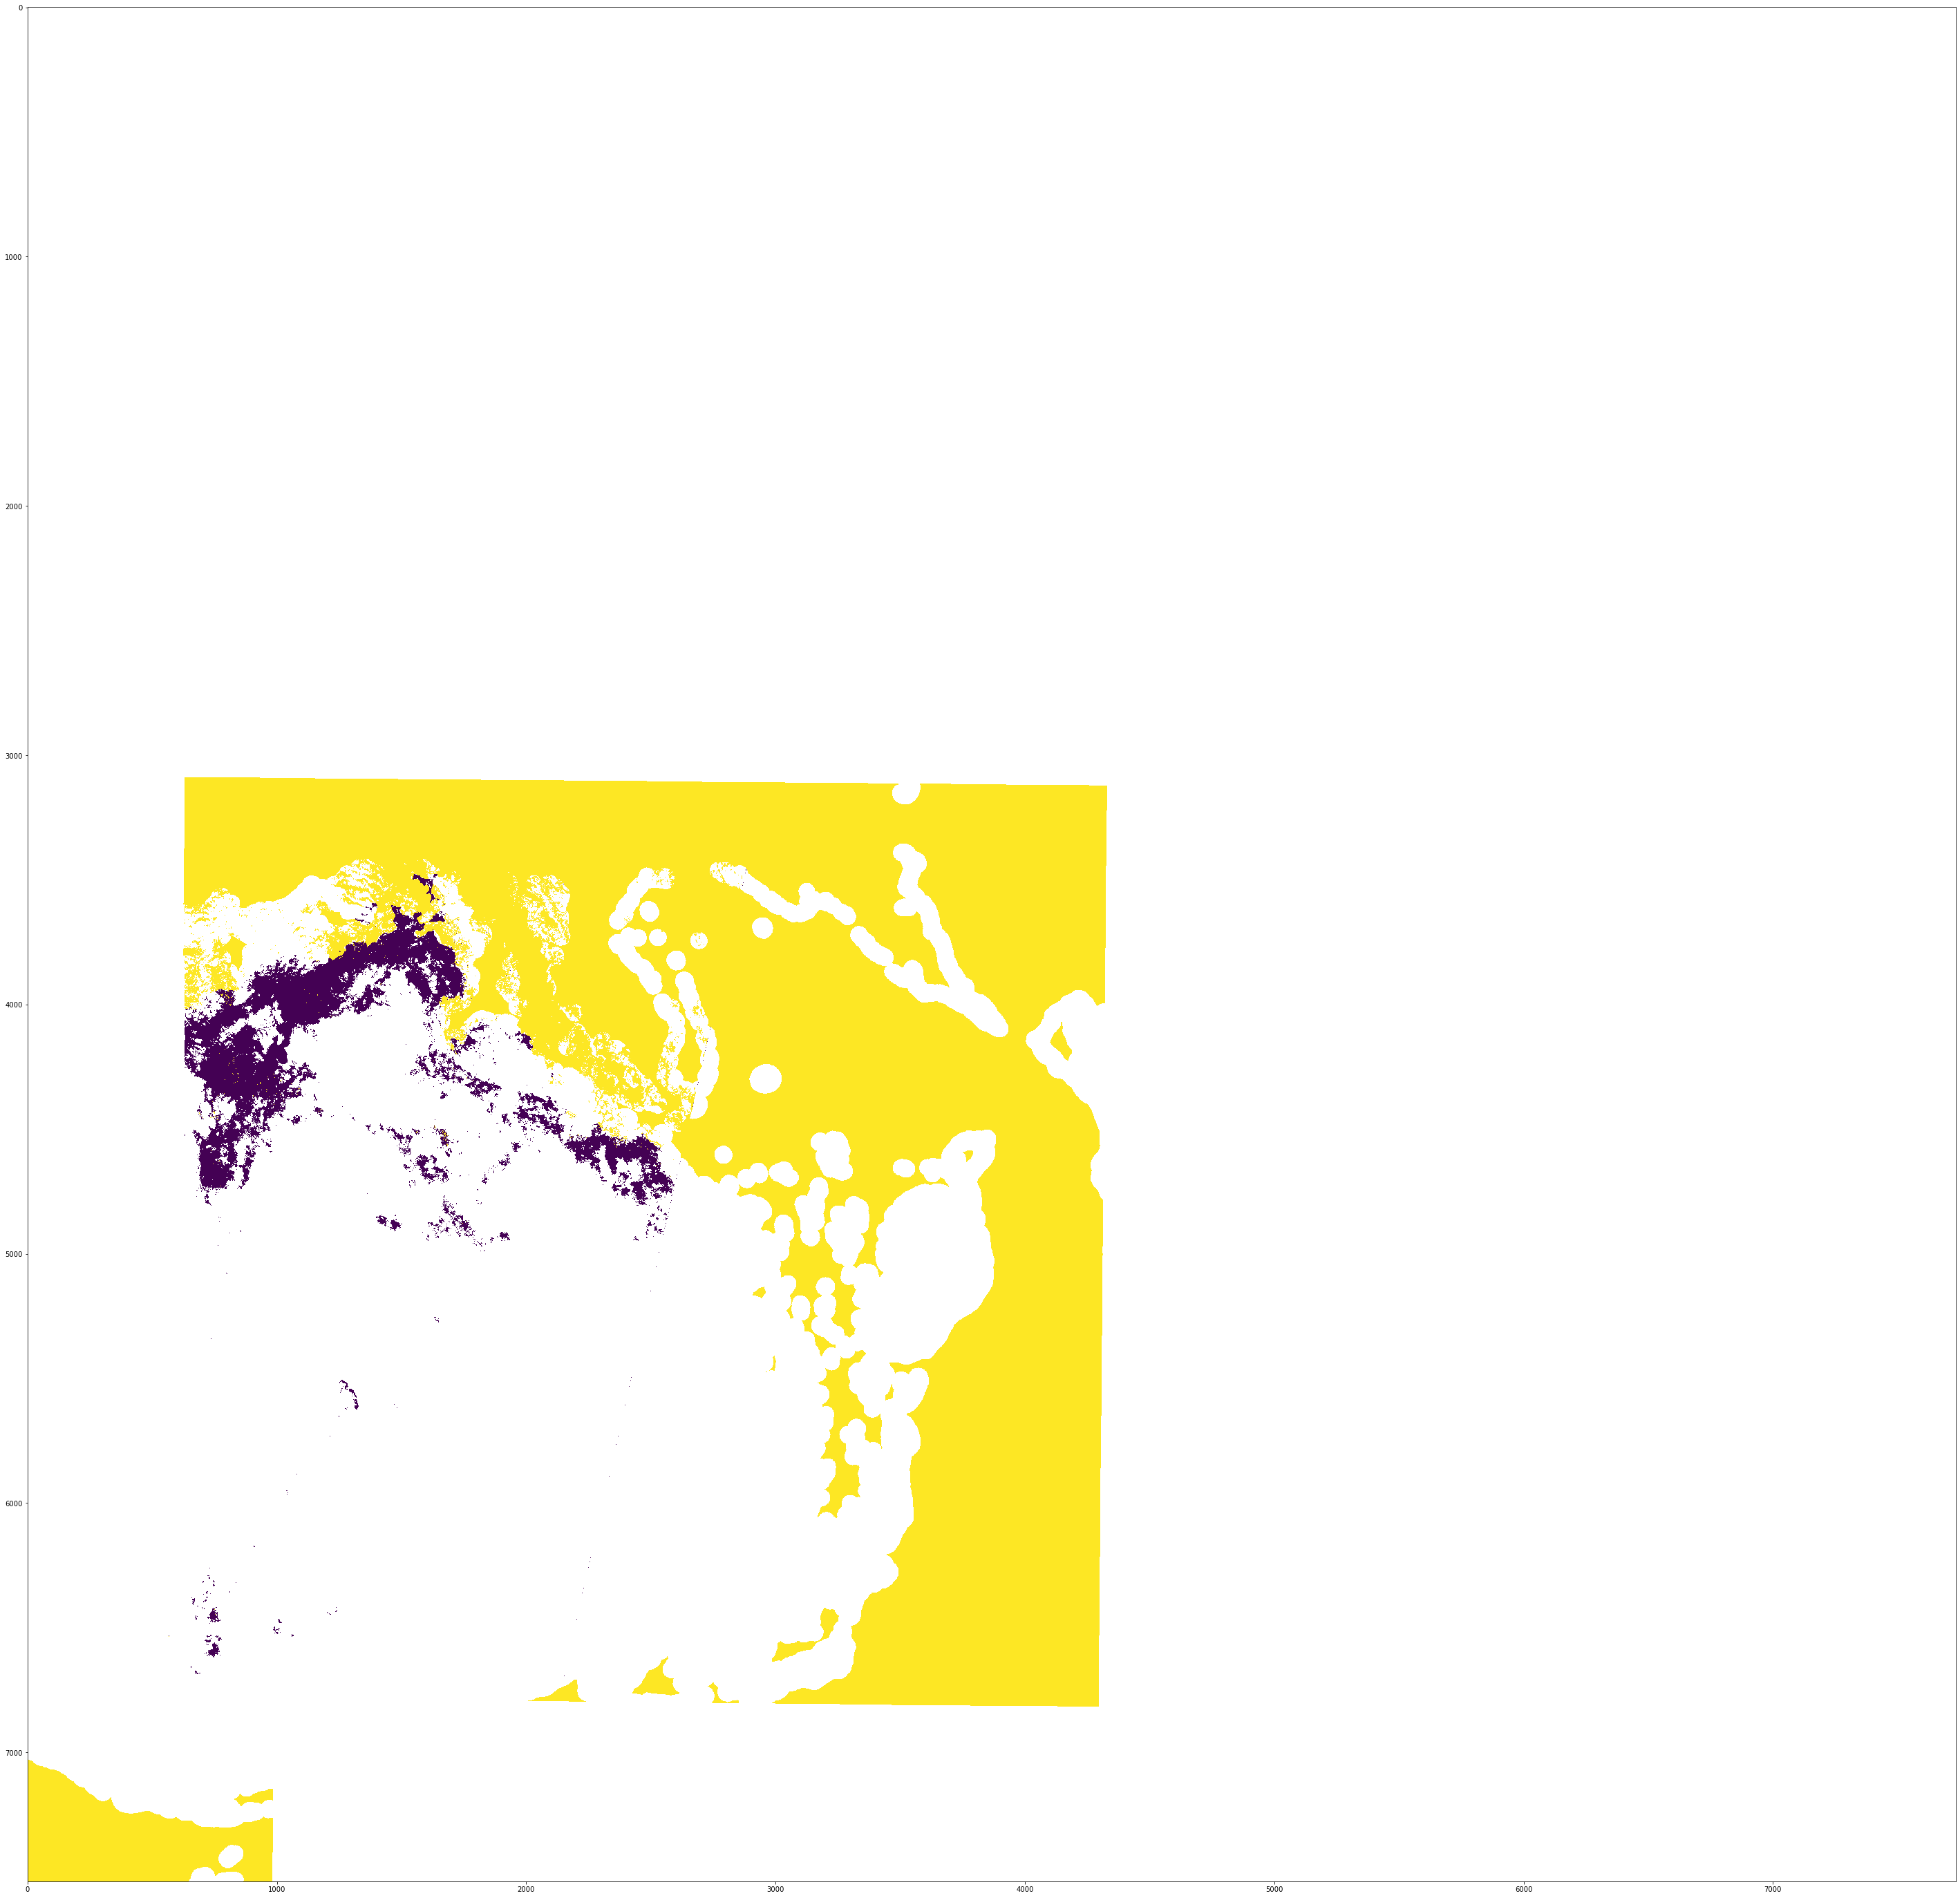

In [40]:
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(water_dataset.isel(time = 0).waterprob)
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(water_dataset.isel(time = 0).watermask)

fully **remove nodata** pixels (can't just use ==-9999 due to potential nn averaging within dc.load() at res <native

In [20]:
# Identify pixels with valid data
good_quality = (
    (water_dataset.water >= 0) # no data
)
# Apply mask
water_dataset = water_dataset.where(good_quality)

In [21]:
water_dataset.nbytes/1000000000

2.790683368

In [22]:
shdf = salem.read_shapefile(buffer_path)

In [23]:
shdf = salem.read_shapefile(buffer_path)
water_dataset.attrs['pyproj_srs'] = str(water_dataset.attrs['crs'])
water_dataset = water_dataset.salem.roi(shape=shdf, other=np.nan)

In [24]:
water_dataset = water_dataset.salem.roi(shape=shdf, other=np.nan)

In [25]:
water_dataset.nbytes/1000000000

2.790683368

**define dask computation** of water summary product

In [26]:
mean_dataset = water_dataset.water.mean(dim='time')

In [27]:
mean_dataset.nbytes/1000000000

0.465093552

**apply computation** to water masks dataset & plot

In [28]:
%%time
mean_dataset = mean_dataset.compute()


KeyboardInterrupt



mask to obvious **ocean buffer**

In [29]:
# %%time
# fig, ax = plt.subplots(figsize=(50,50))
# ax.imshow(mean_dataset)

In [30]:
# del water_dataset
client.restart()

KeyboardInterrupt: 

**create binary water mask** based on summary product (based off likelihood of being persistent water bodies)

In [ ]:
%%time
waterpres_prob = 0.5
T0_nd_water = np.isnan(mean_dataset)
T0_water = mean_dataset.where((mean_dataset < waterpres_prob) | (T0_nd_water == True), 1) # fix > prob to water
T0_water = T0_water.where((T0_water >= waterpres_prob) | (T0_nd_water == True), 0) # fix < prob to no water 

In [ ]:
mean_dataset = None

In [ ]:
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(T0_water)

# **(2) load T1 image**

**load** l8

In [ ]:
product = T1_prod
measurements = T1_measurements

T1_dataset = dc.load(
    product=product,
    time=T1, # 
    lat=latitude,
    lon=longitude,
    output_crs=output_crs,
    resolution=resolution,
    measurements = T1_measurements,
#     group_by='solar_day',
    dask_chunks={
        #'time': 1,
        'x': 1000,
        'y': 1000,
    }
)
T1_dataset

apply **clearsky mask** to image

In [ ]:
# Identify pixels with valid data
if 'usgs' in product:
    good_quality = (
        (T1_dataset.pixel_qa == 322)  | # clear
        (T1_dataset.pixel_qa == 386)  |
        (T1_dataset.pixel_qa == 834)  |
        (T1_dataset.pixel_qa == 898)  |
        (T1_dataset.pixel_qa == 1346) |
        (T1_dataset.pixel_qa == 324)  | # water
        (T1_dataset.pixel_qa == 388)  |
        (T1_dataset.pixel_qa == 836)  |
        (T1_dataset.pixel_qa == 900)  |
        (T1_dataset.pixel_qa == 1348)
    )
elif 's2_esa' in product:
    good_quality = (
        (T1_dataset.scene_classification == 2) | # mask in DARK_AREA_PIXELS
    #     (T1_dataset.scene_classification == 3) | # mask in CLOUD_SHADOWS
        (T1_dataset.scene_classification == 4) | # mask in VEGETATION
        (T1_dataset.scene_classification == 5) | # mask in NOT_VEGETATED
        (T1_dataset.scene_classification == 6) | # mask in WATER
        (T1_dataset.scene_classification == 7)   # mask in UNCLASSIFIED
    )
    
else:
    print('nope')

# Apply mask
T1_dataset = T1_dataset.where(good_quality)

In [ ]:
shdf = salem.read_shapefile(buffer_path)

In [ ]:
T1_dataset.attrs['pyproj_srs'] = str(T1_dataset.attrs['crs'])

In [ ]:
T1_dataset.attrs['pyproj_srs'] = str(T1_dataset.attrs['crs'])
T1_dataset = T1_dataset.salem.roi(shape=shdf, other=np.nan)
# T1_dataset = T1_dataset.where(T1_dataset!=0).astype(np.uint16)

In [ ]:
T1_dataset

**isolate image**

In [ ]:
T1_img = T1_dataset.isel(time = 0)

In [ ]:
%%time
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(T1_img[ref_channel])

# **(3) Data prep**

## (3A) Training prep

**create outside merge of nodata** - T1 img + T0 water mask

In [ ]:
%%time
# create mask
T0_nd_img = np.isnan(T1_img)[ref_channel]
T0_nd = T0_nd_water.where((T0_nd_img == False),True)

# apply mask
Ytrain = T0_water.where((T0_nd == False))
Xtrain = T1_img.where((T0_nd == False))

T0_nd_img = None
T0_nd = None

# fig, ax = plt.subplots(figsize=(50,50))
# ax.imshow(Ytrain)
# fig, ax = plt.subplots(figsize=(50,50))
# # ax.imshow(Xtrain.where(Xtrain[ref_channel]>0)[ref_channel])
# ax.imshow(Xtrain[ref_channel])

**numpify** T1 image data

In [ ]:
%%time
des_vars = T1_vars

lenx, leny = np.shape(Xtrain[ref_channel]) # dims of each raster
dsvals = np.zeros([len(des_vars),lenx, leny]) #set up array based on shape of xr and no. des bands

for i, m in zip(np.arange(0,len(Xtrain.data_vars),1), Xtrain.variables): # loop through bands in xr
    print(i, m)
    if m in des_vars: # only want relevant channels
        vals = np.array(Xtrain[m].values) # extract only the reflectance values
        dsvals[i,:,:] = vals # append to 'master' ND array
# plt.imshow(dsvals[0,:,:])

**re-shape**/flatten T1 data + T0 labels

In [ ]:
Xtrain = dsvals.reshape(dsvals.shape[0], lenx * leny)  # reshape into nbands x 1D arrays
Ytrain = Ytrain.values.flatten()
dsvals = None

Xtrain.shape, Ytrain.shape

**remove coincident nd from arrays** variables

In [ ]:
Xtrain = np.array([i[~np.isnan(i)] for i in Xtrain])
Ytrain = Ytrain[~np.isnan(Ytrain)]
Xtrain = Xtrain.transpose()  # transpose so that bands are read as features
Xtrain.shape, Ytrain.shape

**transpose** variables

In [ ]:
Xtrain = Xtrain.transpose()  # transpose so that bands are read as features

Xtrain.shape, Ytrain.shape

# **(5) Training of T1 using T0 labels**

define **model params**

In [ ]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=9, 
                               bootstrap = True,
                               max_features = 'sqrt',
                               max_depth=5,
                               n_jobs=3,
                               verbose=2
                              )
rf = model.fit(Xtrain, Ytrain)
Xtrain = None
Ytrain = None

**fit model**

In [ ]:
%%time
rf = model.fit(Xtrain, Ytrain)

**score model on training set** - should be replaced with cross-validation

In [ ]:
rf_score = rf.score(Xtrain, Ytrain)
rf_score

In [ ]:
Xtrain = None
Ytrain = None

extract & plot **variable importances**

In [ ]:
importances = rf.feature_importances_

indices = np.argsort(importances)
features = [i for i in T1_img]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

extract and **plot decision tree** - TBC

## (3C) Inference Implementation Prep

**numpify** T1 image data - within merge

In [ ]:
%%time
des_vars = ['green','red','blue','nir','swir1','swir2']

lenx, leny = np.shape(T1_img[ref_channel]) # dims of each raster
dsvals = np.zeros([len(des_vars),lenx, leny]) #set up array based on shape of xr and no. des bands

for i, m in zip(np.arange(0,len(T1_img.data_vars),1), T1_img.variables): # loop through bands in xr
    print(i, m)
    if m in des_vars: # only want relevant channels
        vals = np.array(T1_img[m].values) # extract only the reflectance values
        dsvals[i,:,:] = vals # append to 'master' ND array
# plt.imshow(dsvals[0,:,:])

**re-shape**/flatten T1 data + T1 labels

In [ ]:
Ximp = dsvals.reshape(dsvals.shape[0], lenx * leny)  # reshape into nbands x 1D arrays
dsvals = None
Ximp = Ximp.transpose()  # transpose so that bands are read as features
foundnans = np.isnan(Ximp)
Ximp[foundnans] = 0


Ximp.shape

**replace coincident nd from arrays** variables

**transpose** variables

In [ ]:
Ximp = Ximp.transpose()  # transpose so that bands are read as features

Ximp.shape

In [ ]:
foundnans = np.isnan(Ximp)
Ximp[foundnans] = 0

In [ ]:
Ximp.nbytes/1000000000

# **(6) Implement on full T1 image**

In [ ]:
predicted = rf.predict(Ximp)
predicted = np.array(predicted)

In [ ]:
predicted = rf.predict(Ximp)
predicted = np.array(predicted)
predicted = predicted
predicted[foundnans[:,0]] = -9999
predicted = predicted.astype(np.int16)
predicted = np.reshape(predicted, [lenx, leny])
predicted_ds = T1_dataset
predicted_ds['water_mask'] = (('y','x'), predicted)
predicted = predicted_ds[['water_mask']]
predicted_ds = None
shdf = salem.read_shapefile(buffer_path)
predicted.attrs['pyproj_srs'] = str(predicted.attrs['crs'])
predicted = predicted.salem.roi(shape=shdf, other=1)

probability = rf.predict_proba(Ximp)[:, 1]
probability = np.array(probability)
probability = probability*100
probability[foundnans[:,0]] = -9999
probability = probability.astype(np.int16)
probability = np.reshape(probability, [lenx, leny])
probability_ds = T1_dataset
probability_ds['water_prob'] = (('y','x'), probability)
probability = probability_ds[['water_prob']]
probability_ds = None
shdf = salem.read_shapefile(buffer_path)
probability.attrs['pyproj_srs'] = str(probability.attrs['crs'])
probability = probability.salem.roi(shape=shdf, other=100)

fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(predicted.water_mask.where(predicted.water_mask>=0))
ax.set_title('Inferred Water Mask')
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(probability.water_prob.where(probability.water_prob>=0))
ax.set_title('Inferred Water Probability')
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(T1_img.swir1)
ax.set_title('SWIR1 Channel');

In [ ]:
probability = rf.predict_proba(Ximp)[:, 1]
probability = np.array(probability)

make dataset again

In [ ]:
probability = probability*100
probability[foundnans[:,0]] = -9999
probability = probability.astype(np.int16)
probability = np.reshape(probability, [lenx, leny])
probability_ds = T1_dataset
probability_ds['water_prob'] = (('y','x'), probability)
probability = probability_ds[['water_prob']]
probability_ds = None

In [ ]:
shdf = salem.read_shapefile(buffer_path)
predicted.attrs['pyproj_srs'] = str(predicted.attrs['crs'])
predicted = predicted.salem.roi(shape=shdf, other=1)

In [ ]:
shdf = salem.read_shapefile(buffer_path)
probability.attrs['pyproj_srs'] = str(probability.attrs['crs'])
probability = probability.salem.roi(shape=shdf, other=100)

In [ ]:
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(predicted.water_mask.where(predicted.water_mask>=0))
ax.set_title('Inferred Water Mask')
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(probability.water_prob.where(probability.water_prob>=0))
ax.set_title('Inferred Water Probability')
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(T1_img.swir1)
ax.set_title('SWIR1 Channel');

# **(7) Export(s)**

In [ ]:
from utils_dcal.data_cube_utilities.import_export import export_xarray_to_geotiff
import os

In [ ]:
# export stuff
inter_dir = '/home/jovyan/ml_outputs/water_products/'
scene_nm = original_metadata.uris[0].split('/')[-2] # assumes scenename as dir of indexed metadata 
local_prodir = inter_dir + scene_nm + '/'
os.makedirs(local_prodir, exist_ok=True)
out_mask_prod = local_prodir + scene_nm + '_watermask.tif'
out_prob_prod = local_prodir + scene_nm + '_waterprob.tif'

export_xarray_to_geotiff(predicted, out_mask_prod, bands=['water_mask'], crs="EPSG:3460", x_coord='x', y_coord='y', no_data=-9999)
export_xarray_to_geotiff(probability, out_prob_prod, bands=['water_prob'], crs="EPSG:3460", x_coord='x', y_coord='y', no_data=-9999)

scene_nm, local_prodir, out_mask_prod, out_prob_prod

In [ ]:
%%time
export_xarray_to_geotiff(predicted, out_mask_prod, bands=['water_mask'], crs="EPSG:3460", x_coord='x', y_coord='y', no_data=-9999)

In [ ]:
%%time
export_xarray_to_geotiff(probability, out_prob_prod, bands=['water_prob'], crs="EPSG:3460", x_coord='x', y_coord='y', no_data=-9999)